In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import umap

from pyuoi.decomposition import UoI_NMF_Base, UoI_NMF
from neuropacks import ECOG
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.dimensionality_reduction_utils import *

%matplotlib inline

In [2]:
# create ECOG object
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
#data_path = '/storage/data/ecog/r32_b7.mat'
#grid_path = '/storage/data/ecog/grdid.mat'

ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path)
dead_electrodes = [0, 19, 21]

In [3]:
# create data matrix
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG')

# kill the dead indices
Y[:, dead_electrodes] = 0
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))

In [4]:
# obtain tuning preferences
tuning_path = os.path.join(os.environ['HOME'],
                           'fits/uoineuro/tuning/ecog/ecog_tuning.h5')
tuning_results = h5py.File(tuning_path, 'r')
tuning_coefs = np.median(tuning_results['uoi_lasso_bic/tuning_coefs'], axis=0)
pref_frequencies = calculate_best_frequencies_ecog(tuning_coefs, ecog,
                                                   return_grid=True,
                                                   omit_idxs=dead_electrodes)

# Analyze BCV NMF Results

In [5]:
results_path = os.path.join(os.environ['HOME'],
                            'fits/uoineuro',
                            'dimensionality_reduction/nmf_ecog.h5')

In [6]:
nmf_bcv_results = h5py.File(results_path, 'r')

In [7]:
# extract bcv errors
n_hyperparameters = len(nmf_bcv_results)
n_ranks = len(nmf_bcv_results['l1_ratio0.01_alpha0.001/errors'])
errors = np.zeros((n_hyperparameters, n_ranks))
groups_bcv = []

for idx, hyperparameter in enumerate(list(nmf_bcv_results)):
    groups_bcv.append(nmf_bcv_results[hyperparameter])
    errors[idx] = nmf_bcv_results[hyperparameter]['errors'][:]

In [8]:
min_group_bcv = groups_bcv[np.argmin(np.min(errors, axis=1))]
min_rank_bcv = np.argmin(min_group_bcv['errors']) + 1

In [9]:
print(min_group_bcv)
print(min_rank_bcv)

<HDF5 group "/l1_ratio0._alpha1.0" (1 members)>
29


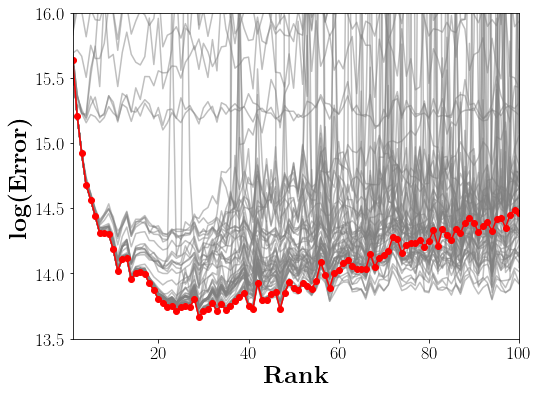

In [10]:
# plot BCV curves and highlight minimum BCV curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# plot all curves
[ax.plot(np.arange(1, 101), np.log(errors[idx]),
         color='gray', alpha=0.5)
 for idx in range(n_hyperparameters)]
# highlight minimum BCV
ax.plot(np.arange(1, 101), np.log(min_group_bcv['errors'][:]),
        marker='o', color='red')

ax.tick_params(labelsize=18)
ax.set_xlim([1, 100])
ax.set_ylim([13.5, 16])
ax.set_xlabel(r'\textbf{Rank}', fontsize=25)
ax.set_ylabel(r'\textbf{log(Error)}', fontsize=25)

plt.savefig('nmf_bcv_results.pdf', bbox_inches='tight')

# Compare NMF and UoI$_{\text{NMF}}$ Basis Sets

In [5]:
# extract components for optimal NMF according to BCV
nmf_bcv = NMF(
    n_components=29,
    l1_ratio=0.0,
    alpha=1.0,
    beta_loss='frobenius',
    solver='cd',
    max_iter=1000,
    init='random').fit(Y)

In [6]:
# examine how bootstrapping in UoI impacts NMF estimates
nmf_for_uoi = NMF(
    n_components=29,
    l1_ratio=0.0,
    alpha=1.0,
    beta_loss='frobenius',
    solver='cd',
    max_iter=1000,
    init='random')

kmeans = KMeans(n_clusters=29, n_init=20)

uoi_bcv_kmeans = UoI_NMF_Base(
    n_boots=30,
    ranks=[29],
    nmf=nmf_for_uoi,
    cluster=kmeans).fit(Y)

In [7]:
# perform UoI NMF with DBSCAN
uoi_bcv_dbscan = UoI_NMF_Base(
    n_boots=30,
    ranks=[29],
    nmf=nmf_for_uoi).fit(Y)

In [14]:
ordering1, ordering2 = match_bases(nmf_bcv.components_,
                                   uoi_bcv_kmeans.components_)

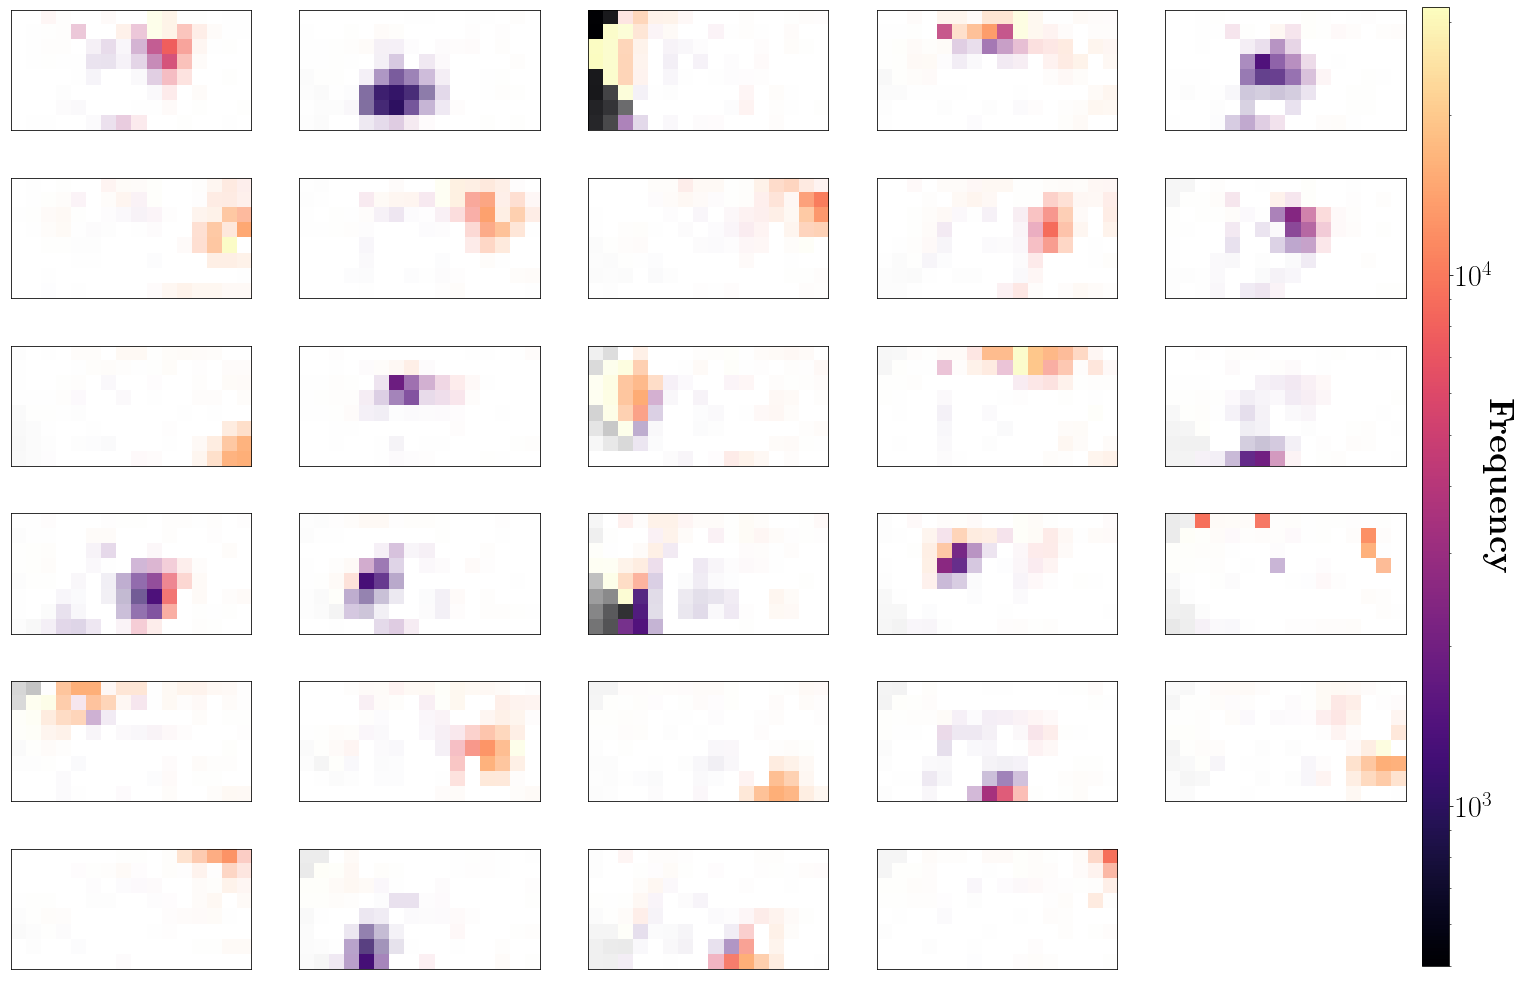

In [15]:
fig, axes = plot_ecog_bases(nmf_bcv.components_, ecog,
                            pref_freqs=pref_frequencies,
                            cmap='magma',
                            ordering=ordering1,
                            n_cols=5)
axes[-1, -1].axis('off')

# create colorbar
fig_invert = fig.transFigure.inverted()
ax_bottom_right_x, ax_bottom_right_y = \
    fig_invert.transform(axes[-1, -1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = \
    fig_invert.transform(axes[0, -1].transAxes.transform([1.0, 1.0]))

cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.01,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.015])
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                   vmax=ecog.freq_set[-1]),
    cmap='magma'
)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=30)
cb.set_label(r'\textbf{Frequency}',
             fontsize=35,
             rotation=270,
             labelpad=20)

plt.savefig('nmf_bcv_components.pdf', bbox_inches='tight')
plt.show()

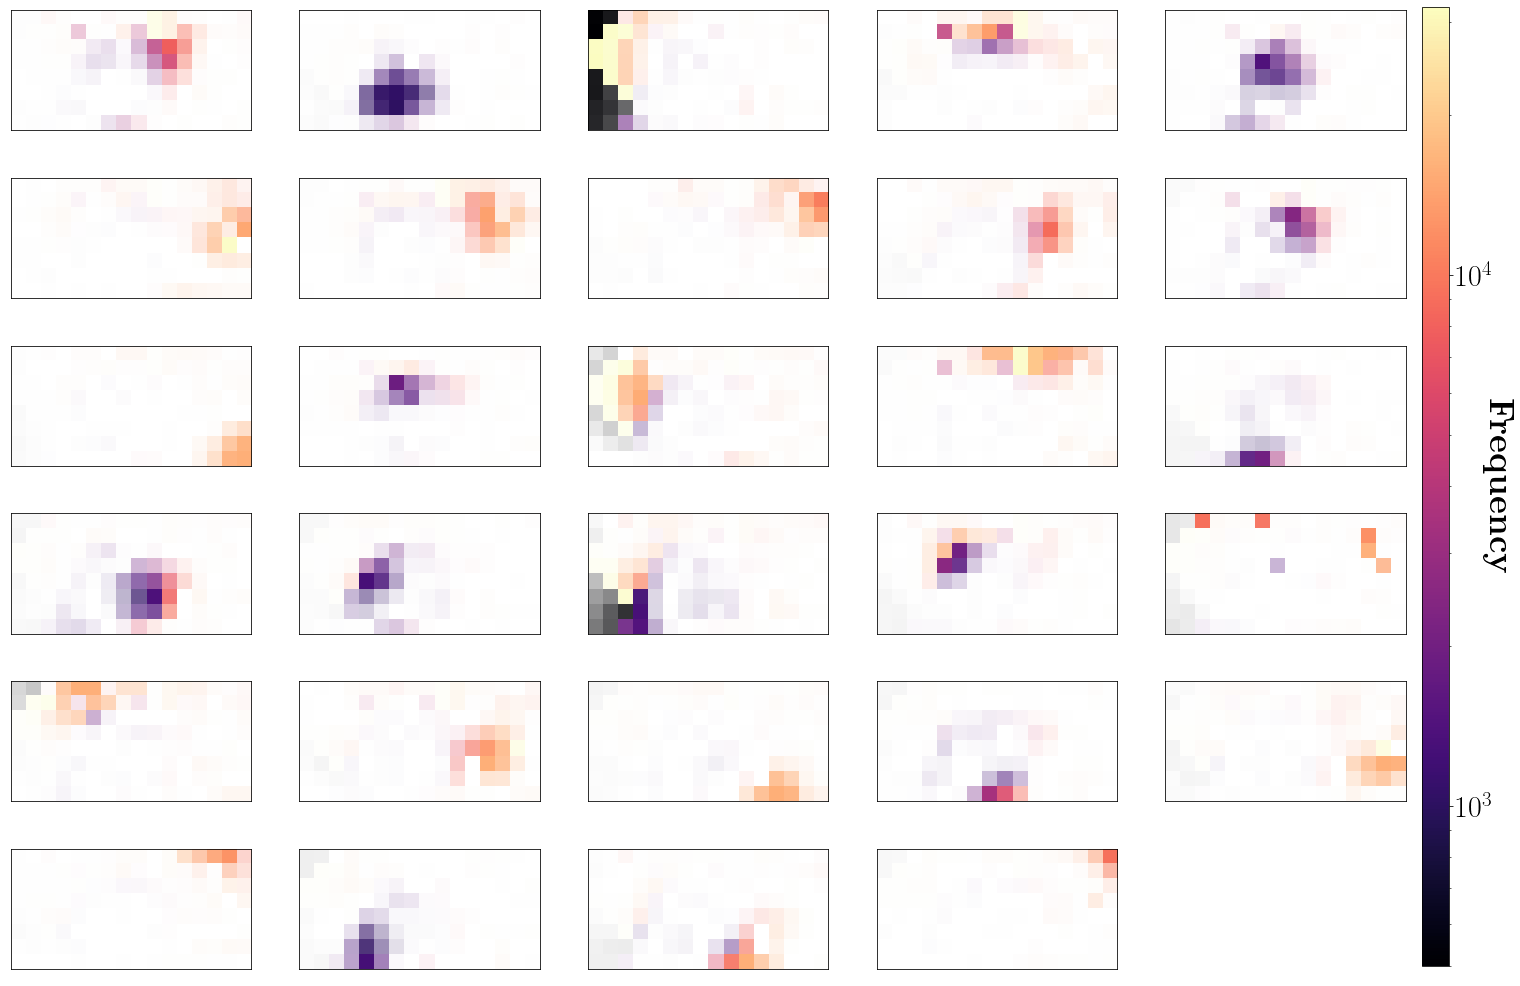

In [16]:
fig, axes = plot_ecog_bases(uoi_bcv_kmeans.components_, ecog,
                            pref_freqs=pref_frequencies,
                            cmap='magma',
                            ordering=ordering2,
                            n_cols=5)
axes[-1, -1].axis('off')

# create colorbar
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.01,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.015])
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                   vmax=ecog.freq_set[-1]),
    cmap='magma'
)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=30)
cb.set_label(r'\textbf{Frequency}',
             fontsize=35,
             rotation=270,
             labelpad=20)

plt.savefig('uoi_nmf_matched_bcv_components.pdf', bbox_inches='tight')
plt.show()

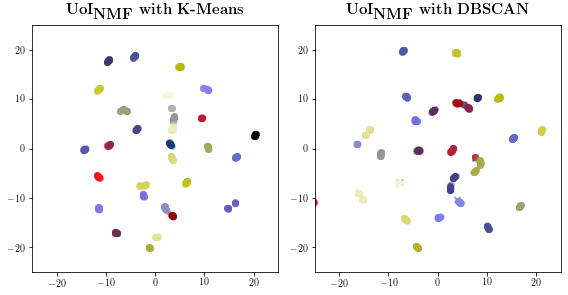

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_embedding(
    samples=uoi_bcv_kmeans.bases_samples_,
    labels=uoi_bcv_kmeans.bases_samples_labels_,
    cmap='gist_stern',
    fax=(fig, axes[0])
)

plot_embedding(
    samples=uoi_bcv_dbscan.bases_samples_,
    labels=uoi_bcv_dbscan.bases_samples_labels_,
    cmap='gist_stern',
    fax=(fig, axes[1])
)

for ax in axes:
    ax.set_xlim([-25, 25])
    ax.set_xticks([-20, -10, 0, 10, 20])
    ax.set_yticks(ax.get_xticks())
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect('equal')
    ax.tick_params(labelsize=10)

axes[0].set_title(r'\textbf{UoI}$_{\textbf{NMF}}$ \textbf{with K-Means}', fontsize=15)
axes[1].set_title(r'\textbf{UoI}$_{\textbf{NMF}}$ \textbf{with DBSCAN}', fontsize=15)
    
plt.tight_layout()
plt.savefig('uoi_nmf_embeddings_matched_bcv.pdf', bbox_inches='tight')

# Analyze UoI NMF Dissimilarity Results

In [32]:
results_path = os.path.join(os.environ['HOME'],
                            'fits/uoineuro/dimensionality_reduction/uoi_nmf_ecog.h5')

In [33]:
uoi_diss_results = h5py.File(results_path, 'r')

In [34]:
n_hyperparameters = len(uoi_diss_results)
n_ranks = len(uoi_diss_results['l1_ratio0.01_alpha0.001/dissimilarity'])
dissimilarities = np.zeros((n_hyperparameters, n_ranks))
groups_diss = []

for idx, hyperparameter in enumerate(list(uoi_diss_results)):
    groups_diss.append(uoi_diss_results[hyperparameter])
    dissimilarities[idx] = uoi_diss_results[hyperparameter]['dissimilarity'][:]
    
kl_dissimilarities = uoi_diss_results['kl/dissimilarity'][:]
dissimilarities_nonan = np.nan_to_num(dissimilarities, nan=100)

In [35]:
list(uoi_diss_results['kl'])

['bases_labels', 'bases_samples', 'components', 'dissimilarity']

In [36]:
min_group_diss = groups_diss[np.argmin(np.min(dissimilarities_nonan, axis=1))]
min_rank_diss = np.argmin(min_group_diss['dissimilarity']) + 2
min_rank_kl = np.argmin(kl_dissimilarities) + 2

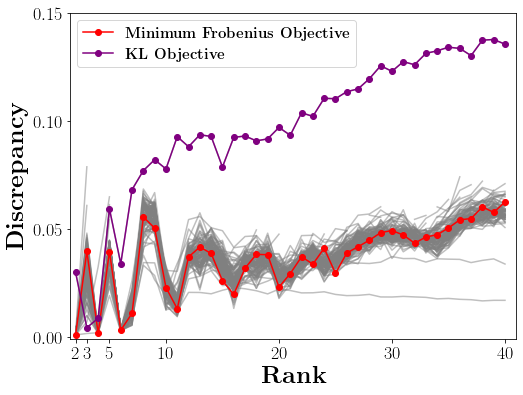

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

[ax.plot(np.arange(2, 41), dissimilarities[idx],
         color='gray', alpha=0.5)
 for idx in range(n_hyperparameters)]

ax.plot(np.arange(2, 41), min_group_diss['dissimilarity'][:],
        color='r',
        label=r'\textbf{Minimum Frobenius Objective}',
        marker='o')

ax.plot(np.arange(2, 41), kl_dissimilarities,
        color='purple',
        label=r'\textbf{KL Objective}',
        marker='o')

ax.set_xlim([1.5, 41])
ax.set_xticks([2, 3, 5, 10, 20, 30, 40])

ax.set_ylim([-0.001, 0.15])
ax.set_yticks([0, 0.05, 0.10, 0.15])

ax.tick_params(labelsize=18)
ax.set_xlabel(r'\textbf{Rank}', fontsize=25)
ax.set_ylabel(r'\textbf{Discrepancy}', fontsize=25)

ax.legend(loc=2, prop={'size': 15})
plt.savefig('uoi_nmf_dissimilarity.pdf', bbox_inches='tight')

## Plot optimal KL divergence solver results

In [39]:
nmf_kl = NMF(
    n_components=3,
    init='random',
    solver='mu',
    beta_loss='kullback-leibler').fit(Y)

In [40]:
ordering1, ordering2 = match_bases(uoi_diss_results['kl/components'][:],
                                   nmf_kl.components_)

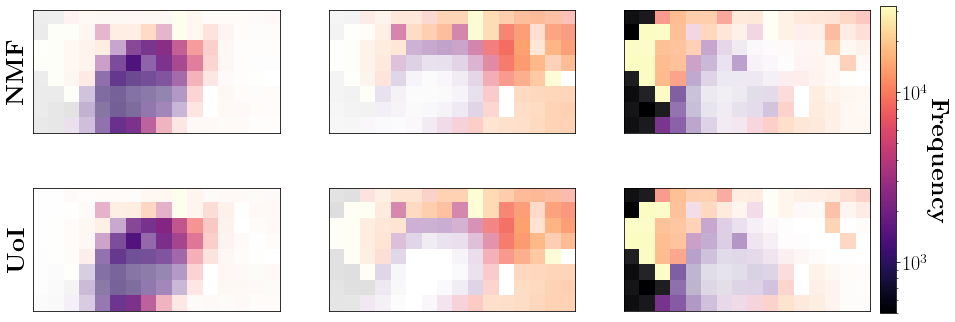

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

plot_ecog_bases(
    uoi_diss_results['kl/components'][:], ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    ordering=ordering1,
    fax=(fig, axes[0]),
    n_cols=3)

plot_ecog_bases(
    nmf_kl.components_, ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    ordering=ordering2,
    fax=(fig, axes[1]),
    n_cols=3)


# create colorbar
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.025,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.045])
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                   vmax=ecog.freq_set[-1]),
    cmap='magma'
)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=20)
cb.set_label(r'\textbf{Frequency}',
             fontsize=25,
             rotation=270,
             labelpad=20)

axes[0, 0].set_ylabel(r'\textbf{NMF}')
axes[1, 0].set_ylabel(r'\textbf{UoI}')

plt.savefig('nmf_optimal_kl_component_comparison.pdf', bbox_inches='tight')

## Plot optimal CD solver results

In [43]:
nmf_cd = NMF(
    n_components=2,
    init='random',
    solver='cd',
    l1_ratio=0.25,
    alpha=2.0,
    beta_loss='frobenius').fit(Y)

In [44]:
ordering1, ordering2 = match_bases(min_group_diss['components'][:],
                                   nmf_cd.components_)

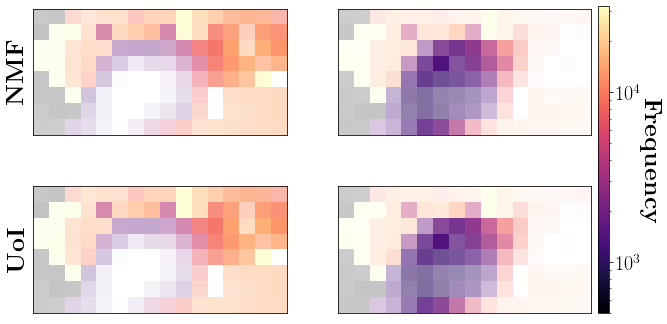

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

plot_ecog_bases(
    min_group_diss['components'][:], ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    fax=(fig, axes[0]),
    ordering=ordering1,
    n_cols=2)

plot_ecog_bases(
    nmf_cd.components_, ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    fax=(fig, axes[1]),
    ordering=ordering2,
    n_cols=2)


# create colorbar
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.025,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.045])
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                   vmax=ecog.freq_set[-1]),
    cmap='magma'
)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=20)
cb.set_label(r'\textbf{Frequency}',
             fontsize=25,
             rotation=270,
             labelpad=20)

axes[0, 0].set_ylabel(r'\textbf{NMF}')
axes[1, 0].set_ylabel(r'\textbf{UoI}')
plt.savefig('nmf_optimal_cd_component_comparison.pdf', bbox_inches='tight')

## Plot Bases with Higher Dissimilarity

In [46]:
nmf_alt = NMF(
    n_components=6,
    init='random',
    solver='cd',
    l1_ratio=0.25,
    alpha=2.0,
    beta_loss='frobenius').fit(Y)

In [47]:
uoi = UoI_NMF(n_boots=30,
              ranks=[6],
              nmf_solver='cd',
              nmf_beta_loss='frobenius',
              nmf_max_iter=1000)
uoi.nmf.set_params(alpha=2.0, l1_ratio=0.25)
uoi.fit(Y)

UoI_NMF(cluster=DBSCAN(algorithm='auto', eps=0.5, leaf_size=30,
                       metric='euclidean', metric_params=None, min_samples=15.0,
                       n_jobs=None, p=None),
        cons_meth=<function mean at 0x11252bd40>, db_algorithm=None,
        db_eps=None, db_leaf_size=None, db_metric=None, db_metric_params=None,
        db_min_samples=None, logger=None, n_boots=30,
        nmf=NMF(alpha=2.0, beta_loss='frobenius', init='random', l1_ratio=0.25,
                max_iter=1000, n_components=6, random_state=None, shuffle=False,
                solver='cd', tol=0.0001, verbose=0),
        nmf_beta_loss=None, nmf_init=None, nmf_max_iter=None, nmf_solver=None,
        nmf_tol=None,
        nnreg=<function UoI_NMF_Base.__initialize.<locals>.<lambda> at 0x1c2e1a4e60>,
        random_state=None, ranks=(6,), use_dissimilarity=True)

In [48]:
ordering1, ordering2 = match_bases(uoi.components_,
                                   nmf_alt.components_)

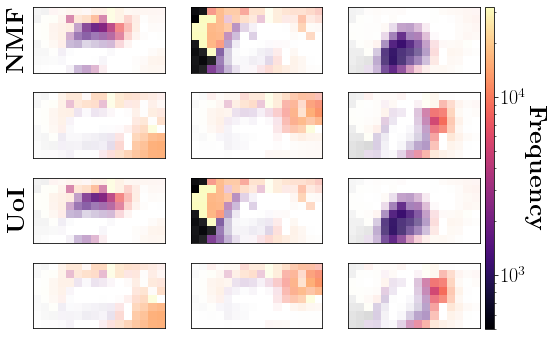

In [50]:
fig, axes = plt.subplots(4, 3, figsize=(8, 6))

plot_ecog_bases(
    uoi.components_, ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    fax=(fig, axes[:2]),
    ordering=ordering1,
    n_cols=2)

plot_ecog_bases(
    nmf_alt.components_, ecog,
    pref_freqs=pref_frequencies,
    cmap='magma',
    fax=(fig, axes[2:]),
    ordering=ordering2,
    n_cols=2)


# create colorbar
cax = fig.add_axes([ax_bottom_right_x + 0.009,
                    ax_bottom_right_y + 0.005,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y - 0.01])
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                   vmax=ecog.freq_set[-1]),
    cmap='magma'
)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=20)
cb.set_label(r'\textbf{Frequency}',
             fontsize=25,
             rotation=270,
             labelpad=20)

axes[0, 0].set_ylabel(r'\textbf{NMF}')
axes[2, 0].set_ylabel(r'\textbf{UoI}')

plt.savefig('nmf_less_optimal_cd_component_comparison.pdf', bbox_inches='tight')